# Diffusion-TS : Interpretable Diffusion for General Time Series Generation



The notebook is a re-implementation of the paper 'Diffusion-TS: interpretable diffusion for general time series generation'.

### Objective of the paper
The objective of the chosen paper is to introduce Diffusion-TS, a novel time series generation model that leverages denoising diffusion probabilistic models (DDPMs) integrated with interpretable seasonal-trend decomposition.

### Methodology
1. <b>Model Structure</b>: The model uses a Transformer-inspired architecture for encoding and decoding time series data.
2. <b>Decomposition</b>: The time series is decomposed into trend, seasonal, and residual components to ensure interpretability.
3. <b>Training</b>: The model is trained using a combination of reconstruction-based guidance and traditional noise prediction parameterization.
4. <b>Dataset</b>: The model’s performance is evaluated on various real-world and synthetic datasets.


### Model
The Diffusion-TS model is a Transformer model, coded in the $\texttt{transformer\textunderscore model.py} $ script, that consists of two main components:
1. <b>Sequence Encoder</b> - $ \texttt{encoder.py} $
2. <b>Interpretable Decoder </b> $ \texttt{- decoder.py} $

#### Encoder
The encoder is characterized by a <u>Full Attention</u> mechanism, which allows the model to focus on relevant parts of the input sequence, and a <u>Feed Forward</u> network that helps in transforming the input data into a suitable representation for further processing.

#### Decoder
The decoder is composed of several layers in which each decoder block contains a <u>Transformer block</u>, a <u>Feed Forward</u> network block and <u>Interpretable Layers</u>.
The Interpretable Layers comprise Trend Layer and Fourier Layer for the representation of trend and seasonality&error respectively.


### Diffusion Framework - DDPM
The diffusion model tipically is subdivided in two processes, forward and reverse. The forward process consists in noise a sample $ x_0 \sim q(x) $ from the data distribution, into a Gussian noise $ x_T \sim \mathcal{N}(0, \mathbf{I}) $. The reverse step instead is learned by a neural network, consisting in gradually denoising the sample via reversed transition. This process can be reduced to learning to build a surrogate approximator to parameterize $ \mu_\theta(x_t, t) $. This objective can be justified as optimizing a weighted variational lower bound on the data log likelihood.


To ensure that the model can unsupervisedly uncover the time-series components, the neural network is trained to predict an estimate of $ \hat{x}_0(x_t, t, \theta) $. The reverse process can then be approximated by the equation:
$$ x_{t-1} = \frac{\sqrt{\bar{\alpha}_t - 1} \beta_t}{1 - \bar{\alpha}_t} \hat{x}_0(x_t, t, \theta) + \frac{\sqrt{\alpha_t(1 - \bar{\alpha}_{t-1})}}{1 - \bar{\alpha}_t} x_t + \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t z_t $$
where $ z_t \sim \mathcal{N}(0, \mathbf{I}) $, $ \alpha_t = 1 - \beta_t $ and $ \bar{\alpha}_t = \prod^t_{s=1}\alpha_s $.

To enhance interpretable diffusion training, it's applied to the frequency domain using the Fourier transform, a mathematical operation that converts a finite-length time-domain signal into its frequency domain representation. The Fourier-based loss term is beneficial for the accurate reconstruction of the time series signals.

$$ \mathcal{L}_\theta = \mathbb{E}_{t, x_0} \left[ w_t \left[ \lambda_1 \| x_0 - \hat{x}_0(x_t, t, \theta) \|^2 + \lambda_2 \| FFT(x_0) - FFT(\hat{x}_0(x_t, t, \theta)) \|^2 \right] \right] $$

$ \lambda_1 $ and $ \lambda_2 $ are weights to balance the loss.

### Disentangled Representation
The disentanglement is achieved by the different <u>Interpretable Layers</u> present in the decoder structure.



#### Trend
Designed to capture the underlying smooth trend in the time series data. The trend represents the general direction or pattern that the data follows over time.
It is modeled using a polynomial regressor that helps fitting a polynomial curve that best represents the behavior of the data.
The trend syntesis is performed by the class TrendLayer in model_classes.py.
The trend component is calculated as:

$$ V_{\text{tr}}^t = \sum_{i=1}^D \left( C \cdot \text{Linear}(w_{\text{tr}}^{i,t}) + X_{\text{tr}}^{i,t} \right) $$


#### Seasonality & Error
Recover automatically the seasonal patterns and distinguish them from the noisy input is the main challenge.
The seasonal component of the time series is captured using Fourier bases, through different steps:
1. Computation of the Fourier transform of the intermadiate activations $ w_{\text{seas}}^{i,t} $ and computation of the amplitude and the phase of the k-th frequency:
$$ A_{i,t}^{(k)} = \left| \mathcal{F}(w_{\text{seas}}^{i,t})_k \right|, \quad \Phi_{i,t}^{(k)} = \phi \left( \mathcal{F}(w_{\text{seas}}^{i,t})_k \right) $$

2. Select the top K amplitudes:
$$ \kappa_{i,t}^{(1)}, \ldots, \kappa_{i,t}^{(K)} = \text{arg TopK}_{k \in \{1, \ldots, \lfloor \tau / 2 \rfloor + 1\}} \left\{ A_{i,t}^{(k)} \right\} $$

3. Reconstruct the seasonal component using the selected frequencies:
$$ S_{i,t} = \sum_{k=1}^K A_{\kappa_{i,t}^{(k)},i,t} \left[ \cos \left( 2\pi f_{\kappa_{i,t}^{(k)}} \tau c + \Phi_{\kappa_{i,t}^{(k)},i,t} \right) + \cos \left( 2\pi \bar{f}_{\kappa_{i,t}^{(k)}} \tau c + \bar{\Phi}_{\kappa_{i,t}^{(k)},i,t} \right) \right] $$

The Fourier synthetic layer selects bases with the most significant amplitudes in the frequency domain, and then returns to the time domain through an inverse transform to model the seasonality.

The following experiments aim to display the capacity of the model. All trainings have been performed using a cpu on a M1 MacBook Air.

## Trend and Seasonality learning - experiment 1

The first experiment is used to show the capability of the system to separate seasonality and trend from the reconstruction of the original data.
The dataset used is not a real dataset, but a syntetic one, customply generated for the purpose. It is in fact a dataset consisting of sine waves with random frequencies, phases and amplitude.

### Imports
Imports if the necessary library functions and scripts functions. Some imports are of utility nature, others are needed for the plot part.

In [1]:
import os
import torch
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from Scripts.trainer import Trainer
from sklearn.preprocessing import MinMaxScaler
from Scripts.utility_func import load_yaml, create_instance_from_config, normalize_to_neg_one_to_one, data_generation
from Scripts.sines import CreateDataset


### Set up

Initialization of:
- the path to the configuration file where a set of configurations is specified
- the output folder

In the $ \texttt{config.yaml} $ file are present several parameters for the model and the training process.

In [ ]:
config_path = './Config/config.yaml'
save_dir = './interpretability/sines/'
gpu = 0
os.makedirs(save_dir, exist_ok=True)

### Data generation
The dataset generation is performed by the $ \texttt{data\textunderscore generation} $ function.
After generation, the data is prepared for training and testing of the model.

In [3]:
data1, data2 = data_generation(1000, seq_len=96, dim=5)

Global seed set to 123


Sampling Data: 100%|██████████| 1000/1000 [00:00<00:00, 1402.47it/s]


In [4]:
scaler = MinMaxScaler()
scaler.fit((data1 + data2).reshape(-1, 5))
season = normalize_to_neg_one_to_one(scaler.transform(data1.reshape(-1, 5)).reshape(data1.shape))
trend = normalize_to_neg_one_to_one(scaler.transform(data2.reshape(-1, 5)).reshape(data2.shape))

train_dataset = CreateDataset(season, trend, period='train')
test_dataset = CreateDataset(season, trend, period='test')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True, sampler=None)

Set up of:
- the trainer object with several parameters
- the model based on the configurations specified in the .yaml file

The model in this first case is set to have 1 layer for the encoder and 2 layers for the decoder.

In [5]:
configs = load_yaml(config_path)
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

model = create_instance_from_config(configs['model']).to(device)
trainer = Trainer(model=model, dataloader={'dataloader':dataloader}, device=device, \
                  train_num_steps=configs['solver']['max_epochs'], \
                  gradient_accumulate_every=configs['solver']['gradient_accumulate_every'], \
                  save_cycle=configs['solver']['save_cycle'], \
                  results_folder=configs['solver']['results_folder'], \
                  start_lr=configs['solver'].get('base_lr', 1.0e-4), \
                  ema_decay=configs['solver']['ema']['decay'], \
                  ema_update_every=configs['solver']['ema']['update_interval'], \
                  sc_cfg=configs['solver']['scheduler'])

### Training
Call of the train loop. 
The training code, contained in the script $ \texttt{trainer.py} $, trains the model by repeatedly feeding batches of data into the model, computing the loss, backpropagating the gradients, and updating the model parameters. 

In the loop is also applied a gradient clipping to prevent exploding gradients.

The script also save check points of the training after a fixed number of epochs.

The seed is set for reprocibility.

In [6]:
trainer.train(seed=123)

Global seed set to 123


loss: 0.041022: 100%|██████████| 1000/1000 [30:18<00:00,  1.82s/it]  

training complete


### Inference
Prepare and execute inference phase on the model. The test data is used for evaluation. The trend, season, residual and input are retrieved by means of the function $ \texttt{return\textunderscore components} $ that taking the state and the timestep, outputs the components of the sample.

In [7]:
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, sampler=None)

In [8]:
data, trend_r, season_r = next(iter(dataloader))
data, trend_r, season_r = data.to(device), trend_r.to(device), season_r.to(device)

interpretable_model = trainer.model.to(device)
interpretable_model.eval()

t = int(interpretable_model.num_timesteps // 2)
trend, season, r, x = interpretable_model.return_components(data, t)

### Visualization

In [34]:
from Scripts.interpr_plots import plot_dirty_input, plot_original_data, plot_reconstruction, plot_original_season, plot_learnt_season, plot_original_trend, plot_learnt_trend, plot_learnt_residual

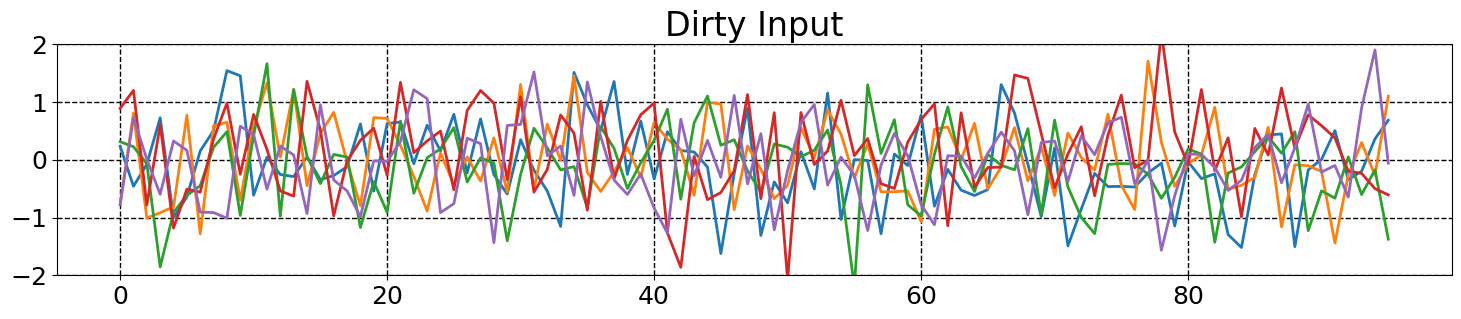

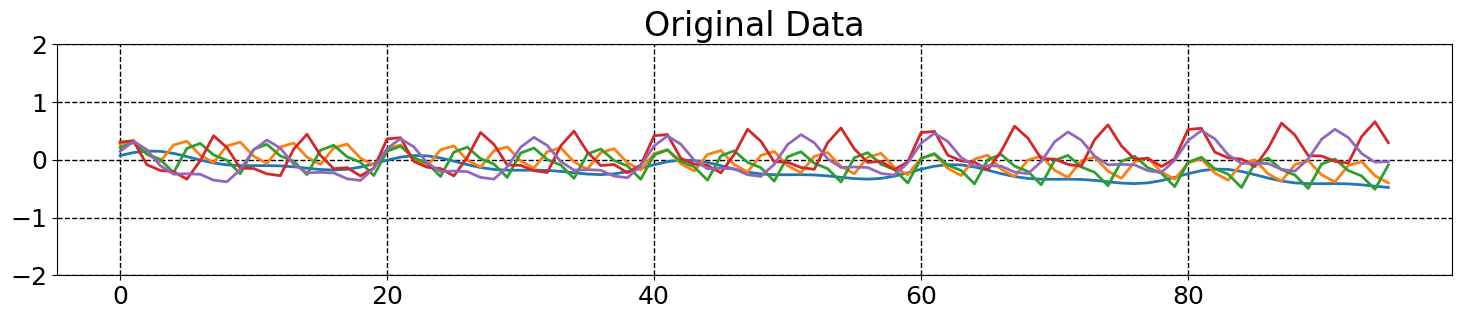

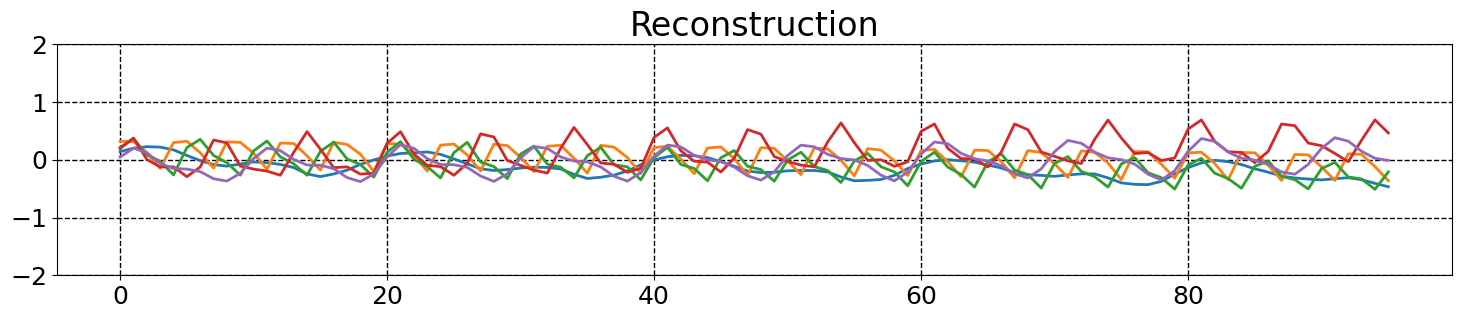

In [35]:
idx, size = 0, 5

dir = save_dir + f'/figures_{2}/'
os.makedirs(dir, exist_ok=True)

plot_dirty_input(idx, size, x, dir)

plot_original_data(idx, size, data, dir)

plot_reconstruction(idx, size, trend, season, r, dir)

The input data that has been subjected to noise or distortions, representing a challenging scenario for the model to handle.

The reconstruction is the combination of the learnt trend, season, and residual components to form the final predicted series.

The reconstructed series closely follows the patterns of the original data, indicating that the model has successfully combined the learnt components to recreate the original series. Even showing minimal deviation from the original data, it suggests accuracy in the model’s predictions.

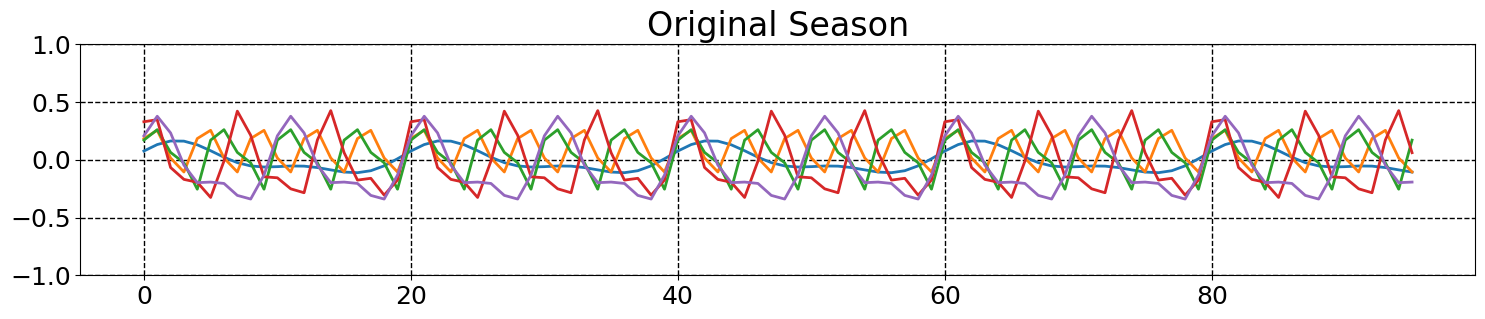

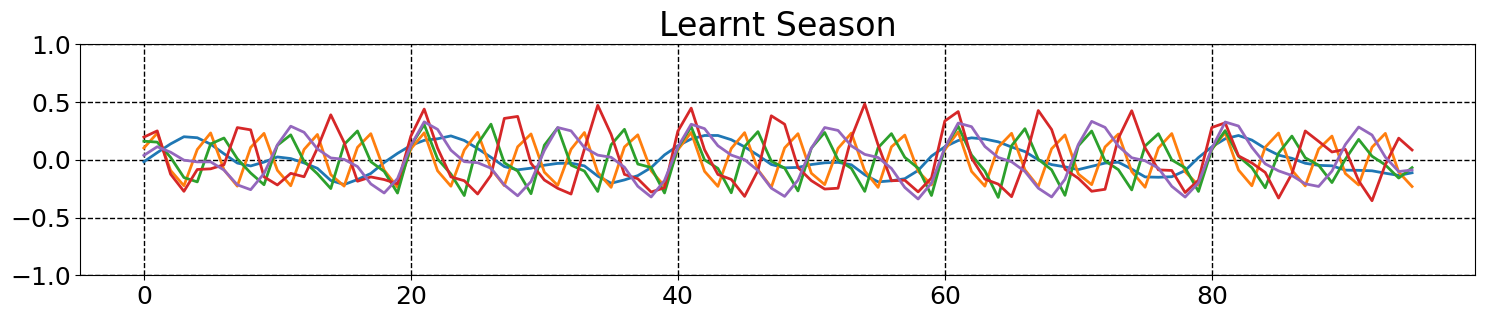

In [36]:
plot_original_season(idx, size, season_r, dir)

plot_learnt_season(idx, size, season, dir)

The seasonal component represents repeating patterns or cycles in the data.

The original seasonal patterns exhibit regular oscillations. Those similar oscillations can be fouind in thethe learnt season plot. The patterns are in fact captured with regular oscillations, indicating that the model has successfully learned the cyclical nature of the data

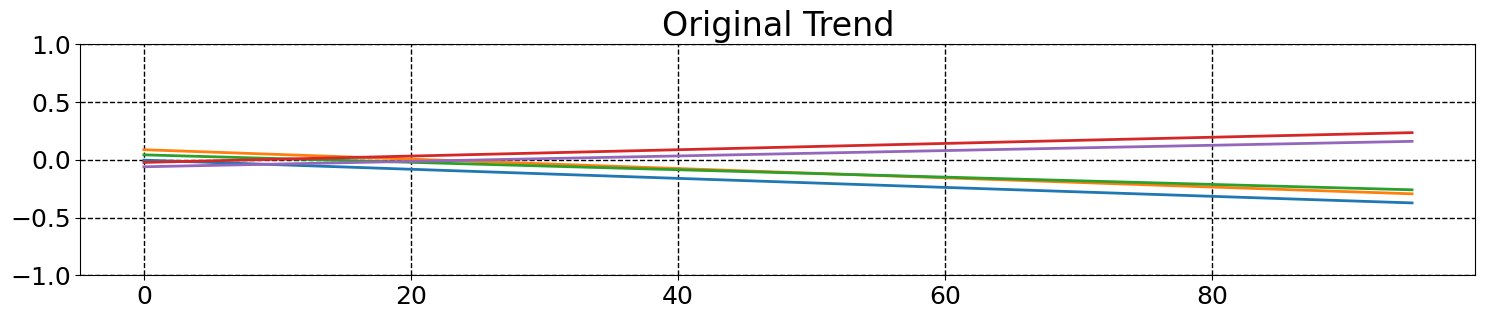

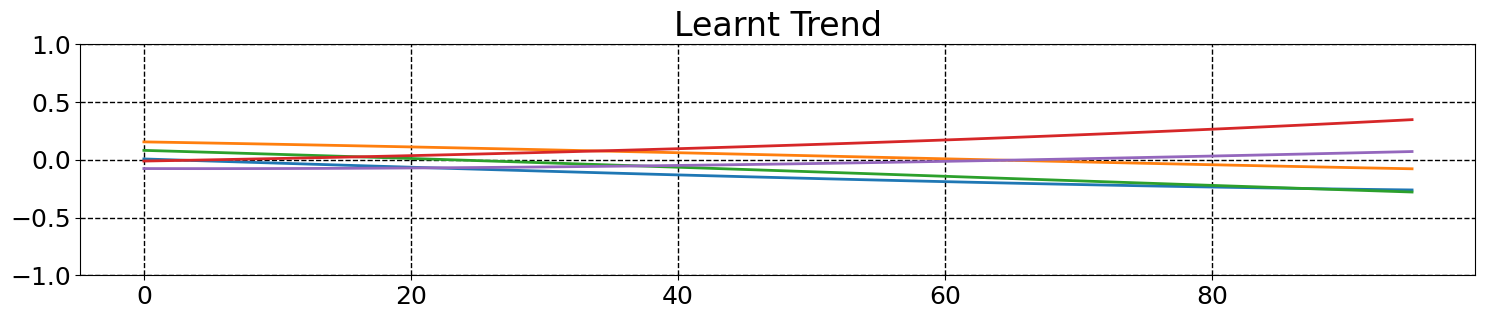

In [37]:
plot_original_trend(idx, size, trend_r, dir)

plot_learnt_trend(idx, size, trend, dir)

The trend component represents the long-term progression of the data points, ignoring short-term fluctuations.

The trend lines are relatively smooth, indicating that the model has successfully captured the long-term progression of the data. Moreover the consistency between the learnt trend and the original trend indicates that the model has effectively captured the true trends in the data.

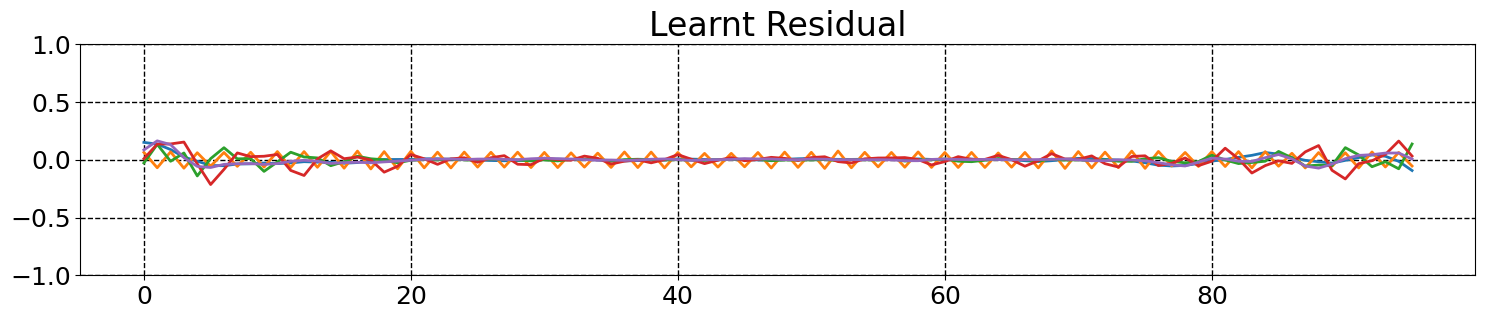

In [38]:
plot_learnt_residual(idx, size, r, dir)

The residuals are the differences between the predicted values and the actual values after training the neural network and should ideally be close to zero, indicating a good fit of the model to the data.
In the plot the residuals are centered around zero, suggesting that the model predictions are close to the actual values.

## Synthetic data generation - experiment 2

The second experiment is used to demonstrate the performance of time series synthesis, by training the network on a high-dimensional dataset like the energy dataset, and afterwards performing long-term time series generation. The efficiently new generated data implies the efficacy of interpretable decomposition for long-term time-series modeling.

Dataset used: energy_data.csv
The Energy dataset is a UCI appliance energy prediction dataset, an experimental data used to create regression models of appliances energy use in a low energy building.

The performance of time series synthesis is visualized in two methods: the projection of the original and synthetic data in a 2-dimensional space using t-SNE, and the draw of the data distributions using kernel density estimation.

### Imports 
Import of the necessary library and functions from the Scripts folder:
- the trainer script for the training of the model
- the data loader to load the dataset located in the Data folder
- some utility functions

In [76]:
import os
import torch
import numpy as np

import warnings
warnings.filterwarnings('ignore', module='tqdm')

from Scripts.trainer import Trainer
from Scripts.get_dataLoader import get_dataloader
from Scripts.utility_func import load_yaml, create_instance_from_config, unnormalize_to_zero_to_one
from Scripts.display import visualization

### Set up

Initialization of:
- the path to the configuration file where a set of configurations is specified
- the output folder
- the data loader for the dataset
- the trainer object with several parameters
- the model based on the configurations specified in the .yaml file

The model for this second case is set to have 4 layers for the encoder and 3 layers for the decoder.

In [77]:
config_path = './Config/energy.yaml'
save_dir = './output/energy/'
gpu = 0
os.makedirs(save_dir, exist_ok=True)

configs = load_yaml(config_path)
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = get_dataloader(configs, save_dir)
model = create_instance_from_config(configs['model']).to(device)
trainer = Trainer(model=model, dataloader=dl_info, device=device, \
                  train_num_steps=configs['solver']['max_epochs'], \
                  gradient_accumulate_every=configs['solver']['gradient_accumulate_every'], \
                  save_cycle=configs['solver']['save_cycle'], \
                  results_folder=configs['solver']['results_folder'], \
                  start_lr=configs['solver'].get('base_lr', 1.0e-4), \
                  ema_decay=configs['solver']['ema']['decay'], \
                  ema_update_every=configs['solver']['ema']['update_interval'], \
                  sc_cfg=configs['solver']['scheduler'])

### Training
Call of the train loop. 
The training code, contained in the script $ \texttt{trainer.py} $, trains the model by repeatedly feeding batches of data into the model, computing the loss, backpropagating the gradients, and updating the model parameters. 

In this case the model has already been trained and the fake data can be already retrieved from the ./output/energy folder.

In [ ]:
# The model is already trained and the checkpoints are already present. => Checkpoints_energy_24
# Skip this cell if you don't want to train the model again
trainer.train(seed=123)

### Inference

Generation of the synthetic data by means of the sample function. The dataset is retrieved, if the <i>fake</i> data is not already present in the output folder, meaning that the data generation has been already performed, the <i>sample</i> function is called and uses the trained model to generate data that is similar to to the original data.

In [78]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
original = np.load(os.path.join(dataset.dir, f"energy_norm_truth_{seq_length}_train.npy"))
print('Original data loaded')
#try catch for case of existing fake data AKA pretrained model for DDPM
try:
    fake_data = np.load(os.path.join(save_dir, f'ddpm_fake_energy.npy'))
    print('Fake data loaded')
except:
    fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
    if dataset.auto_norm:
        fake_data = unnormalize_to_zero_to_one(fake_data)
        np.save(os.path.join(save_dir, f'ddpm_fake_energy.npy'), fake_data)

Original data loaded
Fake data loaded


### Visualization
The results of the inference can be visualized using the two prevously mentioned methods, t-SNE and kernel density estimation.
In the plots both original and synthetic data are displayed.

#### t-SNE
t-Distributed Stochastic Neighbor Embedding is used for embedding high-dimensional data for visualization in a low-dimensional space. The algorithm in fact reduces the dimensionality of the data, making it easier to visualize high-dimensional data in a two-dimensional space.

This method of display is taken from the paper 'Visualizing Data using t-SNE' of Van der Maaten & Hinton, 2008.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 39424 samples in 0.001s...
[t-SNE] Computed neighbors for 39424 samples in 1.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39424
[t-SNE] Computed conditional probabilities for sample 2000 / 39424
[t-SNE] Computed conditional probabilities for sample 3000 / 39424
[t-SNE] Computed conditional probabilities for sample 4000 / 39424
[t-SNE] Computed conditional probabilities for sample 5000 / 39424
[t-SNE] Computed conditional probabilities for sample 6000 / 39424
[t-SNE] Computed conditional probabilities for sample 7000 / 39424
[t-SNE] Computed conditional probabilities for sample 8000 / 39424
[t-SNE] Computed conditional probabilities for sample 9000 / 39424
[t-SNE] Computed conditional probabilities for sample 10000 / 39424
[t-SNE] Computed conditional probabilities for sample 11000 / 39424
[t-SNE] Computed conditional probabilities for sample 12000 / 39424
[t-SNE] Computed conditional probabilities for sa

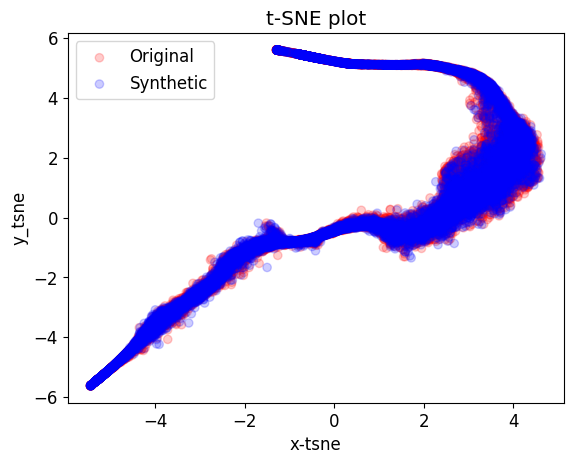

In [79]:
visualization(ori_data=original, generated_data=fake_data, analysis='tsne', save_path=save_dir, compare=original.shape[0])

The plot shows in blue the generated data and in red the original data. 

The significant overlap between the red and blue dots indicates that the synthetic data closely mimics the distribution of the original data. This suggests that the synthetic data generation process was effective in replicating the patterns found in the original data.

#### Kernel density estimation
KDE is a non-parametric way to estimate the probability density function of a random variable. It shows how the data points are distributed over the range of values.

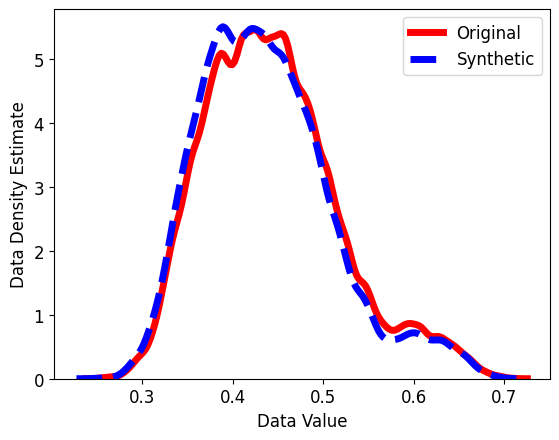

In [80]:
visualization(ori_data=original, generated_data=fake_data, analysis='kernel', save_path=save_dir, compare=original.shape[0])

The KDE plot provides a visual confirmation that the synthetic data closely resembles the original dataset in terms of its probability density distribution, and so the synthetic data has a similar distribution to the original data.

## Synthetic data generation - different dataset

Like in the previous experiment here is performed time-series synthesis, on a different dataset. The one considered here is the Google stock price data from 2019 to July 2024, each observation represents one day and is composed of 6 features.

This dataset is much smaller than the energy one. The results showed imply the efficiency of the network to work also with smaller datasets.

### Imports

In [1]:
import os
import torch
import numpy as np

import warnings
warnings.filterwarnings('ignore', module='tqdm')

from Scripts.trainer import Trainer
from Scripts.get_dataLoader import get_dataloader
from Scripts.utility_func import load_yaml, create_instance_from_config, unnormalize_to_zero_to_one
from Scripts.display import visualization

### Set up

Initialization of:
- the path to the configuration file where a set of configurations is specified
- the output folder
- the data loader for the dataset
- the trainer object with several parameters
- the model based on the configurations specified in the .yaml file

In [2]:
config_path = './Config/stocks_24.yaml'
save_dir = './output/stocks_goog/'
gpu = 0
os.makedirs(save_dir, exist_ok=True)

configs = load_yaml(config_path)
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = get_dataloader(configs, save_dir)
model = create_instance_from_config(configs['model']).to(device)
trainer = Trainer(model=model, dataloader=dl_info, device=device, \
                  train_num_steps=configs['solver']['max_epochs'], \
                  gradient_accumulate_every=configs['solver']['gradient_accumulate_every'], \
                  save_cycle=configs['solver']['save_cycle'], \
                  results_folder=configs['solver']['results_folder'], \
                  start_lr=configs['solver'].get('base_lr', 1.0e-4), \
                  ema_decay=configs['solver']['ema']['decay'], \
                  ema_update_every=configs['solver']['ema']['update_interval'], \
                  sc_cfg=configs['solver']['scheduler'])

In this case the model has already been trained and the fake data can be already retrieved from the ./output/stocks_goog folder.

In [3]:
# The model is already trained and the checkpoints are already present. => Checkpoints_stock_24
# Skip this cell if you don't want to train the model again
trainer.train(seed=123)

Global seed set to 123


loss: 0.103960: 100%|██████████| 10000/10000 [34:52<00:00,  4.78it/s]

training complete


### Inference
Generation of the synthetic data by means of the sample function. The <i>sample</i> function is called if the <i>fake</i> data is not already present in the output folder.

In [4]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
original = np.load(os.path.join(dataset.dir, f"stock_norm_truth_{seq_length}_train.npy"))
print('Original data loaded')
#try catch for case of existing fake data AKA pretrained model for DDPM
try:
    fake_data = np.load(os.path.join(save_dir, f'ddpm_fake_stocks.npy'))
    print('Fake data loaded')
except:
    fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
    if dataset.auto_norm:
        fake_data = unnormalize_to_zero_to_one(fake_data)
        np.save(os.path.join(save_dir, f'ddpm_fake_stocks.npy'), fake_data)

Original data loaded
Global seed set to 123


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 500/500 [08:12<00:00,  1.02it/s]


### Visualization
The generated data is visualizad again by means of two methods t-SNE and kernel density estimation, and compared with the original data.

#### t-SNE
As before the t-SNE graph is one of the techniques used to compare the synthetic dataset and the original one.

/Users/vale/Desktop/Sapienza/Neural Networks/NN_proj/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vale/Desktop/Sapienza/Neural Networks/NN_proj/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2470 samples in 0.000s...
[t-SNE] Computed neighbors for 2470 samples in 0.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2470
[t-SNE] Computed conditional probabilities for sample 2000 / 2470
[t-SNE] Computed conditional probabilities for sample 2470 / 2470
[t-SNE] Mean sigma: 0.055024
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.341656
[t-SNE] KL divergence after 300 iterations: 1.084553


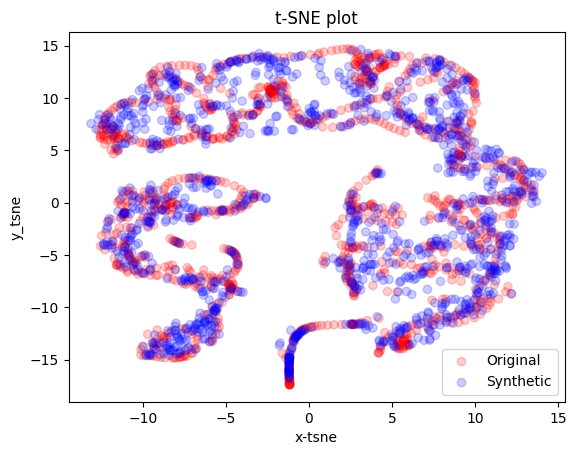

In [5]:
visualization(ori_data=original, generated_data=fake_data, analysis='tsne', save_path=save_dir, compare=original.shape[0])

Again in this case the t-SNE representation of the original and synthetic data shows the effective replicate of the patterns found in the original data, even with sliglthly worse results with respect to the previous dataset.

#### Kerned density estimation

/Users/vale/Desktop/Sapienza/Neural Networks/NN_proj/Scripts/display.py:80: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/Users/vale/Desktop/Sapienza/Neural Networks/NN_proj/Scripts/display.py:81: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/m

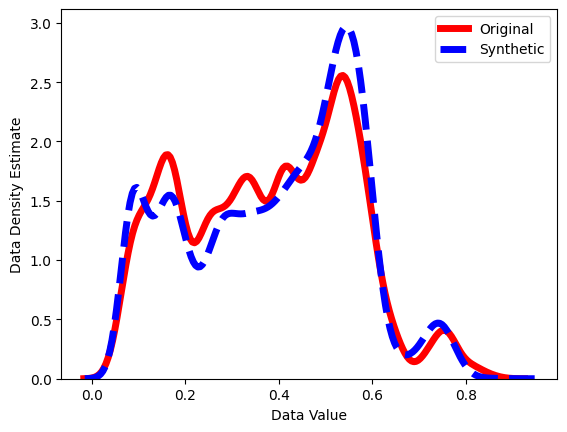

In [6]:
visualization(ori_data=original, generated_data=fake_data, analysis='kernel', save_path=save_dir, compare=original.shape[0])

In the plot the probability density distribution of the synthetic data resembles the original one, but following the line of the t-SNE plot, there is a small difference from the original and the generated data, in particular in the small peaks in the central part of the curve.

# TODO just comment not rerun, to preserve images

## Forecasting - experiment 3

In [105]:
import os
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore', module='tqdm')

from Scripts.trainer import Trainer
from Scripts.get_dataLoader import get_dataloader_cond, get_dataloader
from Scripts.utility_func import load_yaml, create_instance_from_config, unnormalize_to_zero_to_one, normalize_to_neg_one_to_one

In [106]:
config_path = './Config/stocks_48.yaml'
save_dir = './output/stocks_forecasting/'
gpu = 0
mode = 'predict'
pred_len = 12
milestone = 10
os.makedirs(save_dir, exist_ok=True)

configs = load_yaml(config_path)
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = get_dataloader_cond(configs, mode=mode, missing_ratio=None, pred_len=pred_len, save_dir=save_dir)
model = create_instance_from_config(configs['model']).to(device)
trainer = Trainer(model=model, dataloader=dl_info, device=device, \
                  train_num_steps=configs['solver']['max_epochs'], \
                  gradient_accumulate_every=configs['solver']['gradient_accumulate_every'], \
                  save_cycle=configs['solver']['save_cycle'], \
                  results_folder=configs['solver']['results_folder'], \
                  start_lr=configs['solver'].get('base_lr', 1.0e-4), \
                  ema_decay=configs['solver']['ema']['decay'], \
                  ema_update_every=configs['solver']['ema']['update_interval'], \
                  sc_cfg=configs['solver']['scheduler'])

In [50]:
trainer.load(milestone)
dataloader, dataset = dl_info['dataloader'], dl_info['dataset']
coef = configs['dataloader']['test_dataset']['coefficient']
stepsize = configs['dataloader']['test_dataset']['step_size']
sampling_steps = configs['dataloader']['test_dataset']['sampling_steps']
seq_length, feature_dim = dataset.window, dataset.var_num
samples, original, masks = trainer.restore(dataloader, [seq_length, feature_dim], coef, stepsize, sampling_steps)

Global seed set to 123


conditional sampling loop time step: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


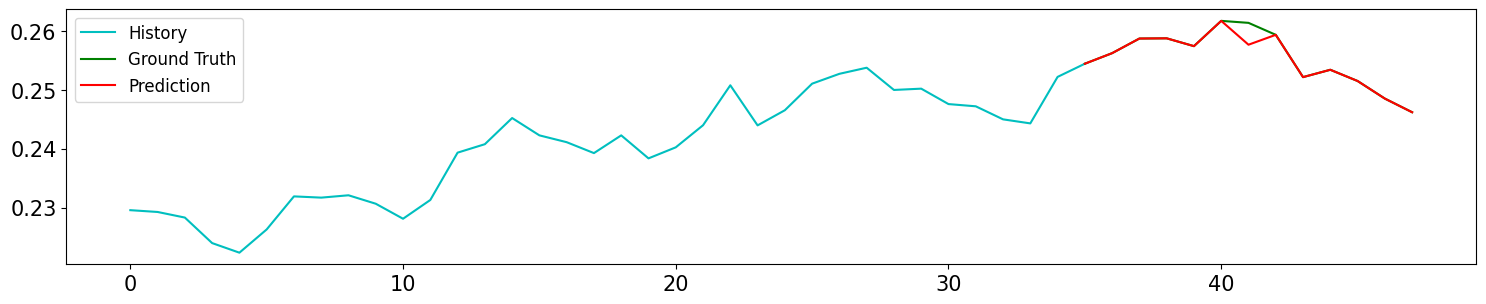

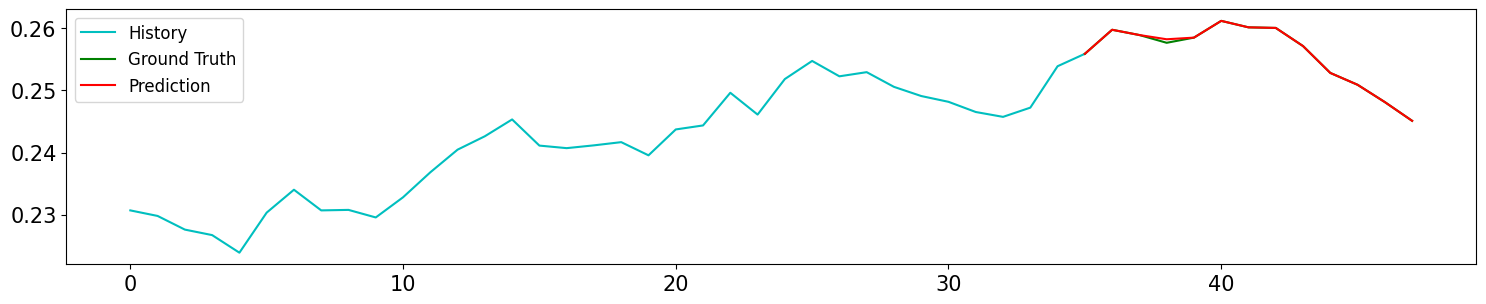

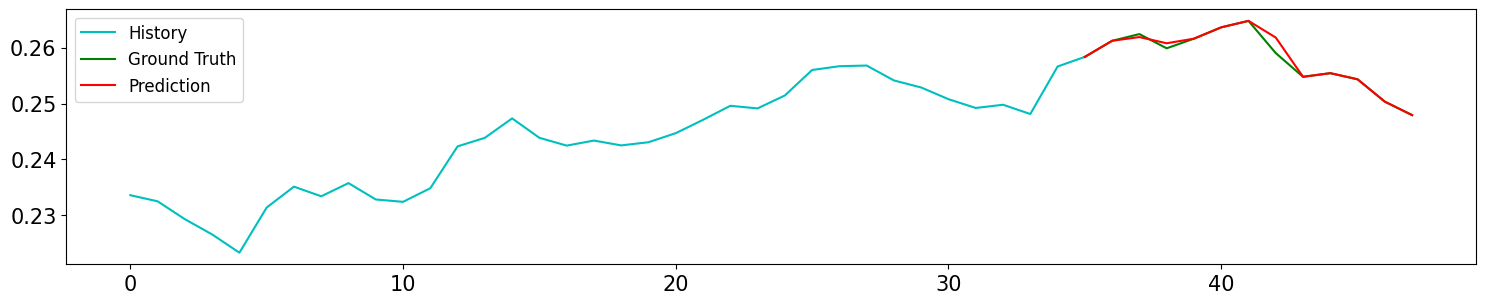

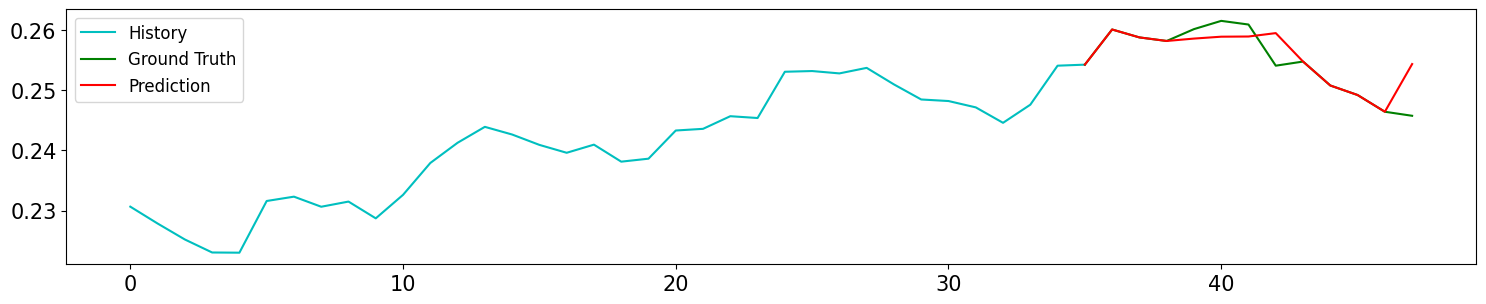

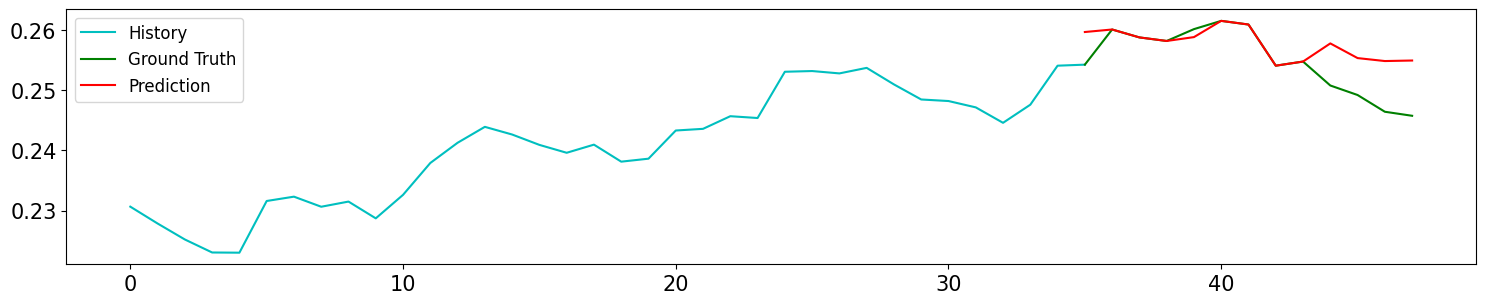

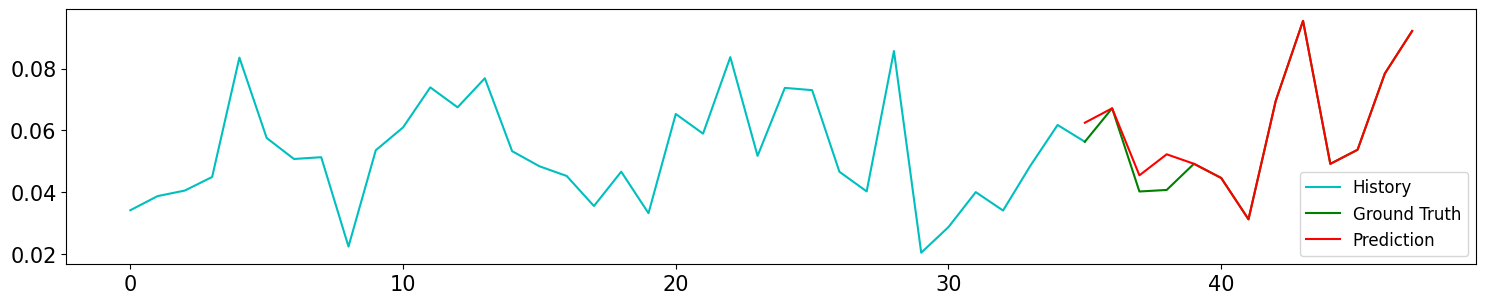

In [72]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 12
pred_length = 12

for idx in range(6):
    plt.figure(figsize=(15, 3))
    plt.plot(range(0, seq_length-pred_length), original[0, :(seq_length-pred_length), idx], color='c', linestyle='solid', label='History')
    plt.plot(range(seq_length-pred_length-1, seq_length), original[0, -pred_length-1:, idx], color='g', linestyle='solid', label='Ground Truth')
    plt.plot(range(seq_length-pred_length-1, seq_length), samples[0, -pred_length-1:, idx], color='r', linestyle='solid', label='Prediction')
    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    plt.legend()
    # plt.savefig(f'./output/stocks_forecasting/figures/forecast_{idx}.png')
    plt.show()